# Проект для «Викишоп»

### Описание проекта
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

* Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

* Постройте модель со значением метрики качества *F1* не меньше 0.75. 

---

<h2>Содержание</h2>

<div class="toc">
  <ul>
    <li><a href="#Подготовка">Подготовка</a></li>
    <li><a href="#Обучение">Обучение</a></li>
       <ul>
        <li><a href="#LogisticRegression">LogisticRegression</a></li>
        <li><a href="#RandomForestClassifier">RandomForestClassifier</a></li>
        <li><a href="#CatBoostClassifier">CatBoostClassifier</a></li>
      </ul>
    <li><a href="#Тестирование">Тестирование</a></li>
    <li><a href="#Общий-вывод">Общий вывод</a></li>
  </ul>
</div>

<style>
  .toc ul {
    font-size: 14px;
  }
</style>

---

### Цели и задачи

**Цель** - Обучить модель классифицировать комментарии на позитивные и негативные..

**Задачи**:
    
    1. Загрузить и осмотреть данные.  
    2. Подготовить данные для обучения моделей.
    3. Обучение моделей и тестирование лучшей.
    4. Сделать выводы по итогам работы.
    
---

### Описание данных

Столбец `text` текст комментария, а `toxic` — целевой признак.

---

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
import re
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score

pd.set_option('display.max_colwidth', 1000)
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
df = pd.read_csv("C:/Users/Dell/Desktop/Data_YP/Data/text/toxic_comments.csv")

In [3]:
display(df.info())
display(df.head(10))
print('\nЧисло дубликатов:', df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0
9,9,alignment on this subject and which are contrary to those of DuLithgow,0



Число дубликатов: 0


"Unnamed: 0" - не информативный столбец. Удалим его.

In [4]:
df = df.drop(["Unnamed: 0"], axis = 1)

Проверим целевой признак на дисбаланс классов

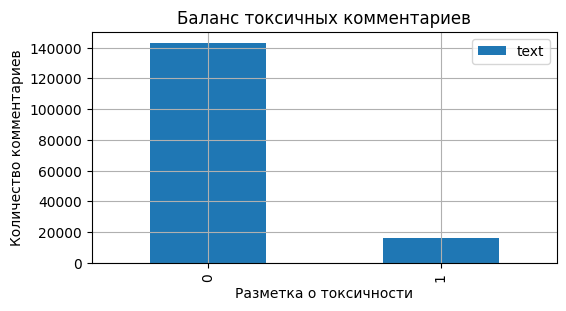

0    0.898388
1    0.101612
Name: toxic, dtype: float64

In [5]:
(df
    .pivot_table(index='toxic', values='text', aggfunc='count')
    .plot(kind='bar', title='Баланс токсичных комментариев', grid=True, figsize=(6,3))
)
plt.xlabel('Разметка о токсичности')
plt.ylabel('Количество комментариев')
plt.show()
df["toxic"].value_counts(normalize = True)

В нашем целевом признаке отрицательных комментариев ≈ 10% , положитительные комментарии ≈ 90%. С уверенностью можем сказать, что имеется дисбаланс. При обучении учтем это.

In [6]:
lemmatizer = WordNetLemmatizer()
nltk.download('averaged_perceptron_tagger')
     
def penn2morphy(penntag):#  присваиваем POS-tag определенный токен (части речи) каждому слову
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def lemmatize_text(text):
    text = text.lower()# некоторые комментарии написаны в верхнем регистре
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', text) #регэксп
    lemm_text =" ".join([lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag))# леммитизируем текст 
                         for word, tag in pos_tag(nltk.word_tokenize(cleared_text))])
    return " ".join(lemm_text.split()) 

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [7]:
df['lemm_text'] = df['text'].progress_apply(lemmatize_text)
df.head()

  0%|          | 0/159292 [00:00<?, ?it/s]

,text,toxic,lemm_text
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation why the edits make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after i vote at new york doll fac and please don t remove the template from the talk page since i m retire now
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,d aww he match this background colour i m seemingly stick with thanks talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man i m really not try to edit war it s just that this guy be constantly remove relevant information and talk to me through edits instead of my talk page he seem to care more about the formatting than the actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,more i can t make any real suggestion on improvement i wonder if the section statistic should be later on or a subsection of type of accident i think the reference may need tidy so that they be all in the exact same format ie date format etc i can do that later on if no one else do first if you have any preference for format style on reference or want to do it yourself please let me know there appear to be a backlog on article for review so i guess there may be a delay until a reviewer turn up it s list in the relevant form eg wikipedia good article nomination transport
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,you sir be my hero any chance you remember what page that s on


Лемматизация прошла успешно. Разобьем выборку на тренировочную и тестовую в отношении 90/10.

In [8]:
target = df['toxic']
features = df['lemm_text']

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.1, 
                                                                            random_state=54321)
print(features_train.shape)
print(features_test.shape)

(143362,)
(15930,)


In [9]:
# Векторизация данных
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stopwords = nltk_stopwords.words('english')

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train_idf = count_tf_idf.fit_transform(features_train)
features_test_idf = count_tf_idf.transform(features_test)

features_train_idf = pd.DataFrame.sparse.from_spmatrix(features_train_idf, columns=count_tf_idf.get_feature_names_out())
features_test_idf = pd.DataFrame.sparse.from_spmatrix(features_test_idf, columns=count_tf_idf.get_feature_names_out())

print(features_train_idf.shape)
print(features_test_idf.shape)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(143362, 146541)
(15930, 146541)


Количество признаков одинаково.

### Вывод

- Провели очистку от лишних символов и лемматизацию слов корпуса
- Разделили обработанные данные на тренировочную и тестовую
- Векторизировали данные
- Данные подготовленны для обучения

## Обучение

### LogisticRegression

In [10]:
classificator = LogisticRegression(random_state=1, n_jobs=-1)
params = [{
           'logisticregression__class_weight':['balanced'],
           'logisticregression__C': range(5,15),
           "logisticregression__verbose":[100], "logisticregression__solver":["saga","sag"]}]

pipe_lr = make_pipeline (count_tf_idf, classificator)

LR = RandomizedSearchCV(pipe_lr, params, scoring='f1',cv=3)
LR.fit(features_train, target_train)

LR_best_params = LR.best_params_
print("Лучшие гиппепараметры:", LR_best_params)

LR_f1 = LR.best_score_
print('\n F1 на LogisticRegression =', LR_f1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   15.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Don

### RandomForestClassifier

In [11]:
classificator = RandomForestClassifier(random_state = 1, n_jobs=-1)
param = [{"verbose":[100]}]

pipe_rfc = make_pipeline (count_tf_idf, classificator)

RFC = RandomizedSearchCV(pipe_rfc, param, scoring='f1',cv=3)
RFC.fit(features_train, target_train)
RFC_best_params = RFC.best_params_
print("Лучшие гиперпараметры:", RFC_best_params)

RFC_f1 = RFC.best_score_
print('\n F1 на RandomForestClassifier:', RFC_f1)

[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=   7.0s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, total= 9.5min
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=   6.7s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, total=10.4min
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=   7.9s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, total=10.5min
[Pipeline] ... (step 1 of 2) Processing tfidfvectorizer, total=  11.5s
[Pipeline]  (step 2 of 2) Processing randomforestclassifier, total=20.3min
Лучшие гиперпараметры: {'verbose': 100}

 F1 на RandomForestClassifier: 0.6869083836114843


### CatBoostClassifier

In [12]:
classificator = CatBoostClassifier(verbose=100, iterations=200)

pipe_cbc = make_pipeline (count_tf_idf, classificator)

pipe_cbc.fit(features_train, target_train)
target_predict = pipe_cbc.predict(features_test)
CBC_f1 = cross_val_score(pipe_cbc,
                      features_train, 
                      target_train, 
                      cv=3, 
                      scoring='f1').max()


print('F1 на CatBoostClassifier:', CBC_f1)

Learning rate set to 0.375567
0:	learn: 0.3922086	total: 7.1s	remaining: 23m 33s
100:	learn: 0.1265953	total: 3m 39s	remaining: 3m 34s
199:	learn: 0.1105785	total: 7m 13s	remaining: 0us
Learning rate set to 0.31586
0:	learn: 0.4334845	total: 1.77s	remaining: 5m 53s
100:	learn: 0.1299119	total: 2m 48s	remaining: 2m 45s
199:	learn: 0.1111492	total: 5m 33s	remaining: 0us
Learning rate set to 0.315861
0:	learn: 0.4363359	total: 1.93s	remaining: 6m 24s
100:	learn: 0.1308510	total: 2m 52s	remaining: 2m 48s
199:	learn: 0.1108237	total: 5m 37s	remaining: 0us
Learning rate set to 0.315861
0:	learn: 0.4346358	total: 1.96s	remaining: 6m 30s
100:	learn: 0.1292453	total: 2m 50s	remaining: 2m 46s
199:	learn: 0.1104642	total: 5m 34s	remaining: 0us
F1 на CatBoostClassifier: 0.7452909418116377


### Вывод

In [13]:
# выводим результаты
comparison_tabl = pd.DataFrame(index=['Результат F1'], columns=['CatBoostClassifier','RandomForestClassifier', 'LogisticRegression'])
comparison_tabl['CatBoostClassifier'] =  CBC_f1
comparison_tabl['RandomForestClassifier'] =  RFC_f1
comparison_tabl['LogisticRegression'] =  LR_f1
comparison_tabl

,CatBoostClassifier,RandomForestClassifier,LogisticRegression
Результат F1,0.745291,0.686908,0.756097


LogisticRegression единственная модель которая прошла порог F1 в 0,75. Проверем ее на тесте.

## Тестирование

In [14]:
predict_LR = LR.predict(features_test)
test_f1 = f1_score(target_test, predict_LR)
print('F1 при обучении', LR_f1)
print('F1 на тесте', test_f1)

F1 при обучении 0.7560969842733214
F1 на тесте 0.7500742942050521


Тест успешно пройден.

## Общий вывод

В ходе работы были выполнены следующие этапы 
- Преподготовка данных для обучения.
- Обучены 3 модели, *CatBoostClassifier*, *RandomForestClassifier*, *LogisticRegression* и получены их результаты.
- Проведено успешное тестирование лучшей модели *LogisticRegression*. 

В итоге, обучена модель способная классифицировать комментарии на позитивные и негативные. Значением метрики модели качества F1 выше 0.75.